# Setup

## Imports

In [1]:
import csv
import os
import pandas as pd
from crossref.restful import Works # crossref api to get metadata using DOI
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

## Functions

### Loader functions

In [2]:
def save_smaller_tsv(input_file_path, output_file_path, num_rows=1000):
    try:
        with open(input_file_path, mode='r', newline='', encoding='utf-8') as infile:
            tsv_reader = csv.reader(infile, delimiter='\t')
            
            with open(output_file_path, mode='w', newline='', encoding='utf-8') as outfile:
                tsv_writer = csv.writer(outfile, delimiter='\t')
                
                for i, row in enumerate(tsv_reader):
                    if i >= num_rows:
                        break
                    tsv_writer.writerow(row)
        
        print(f"Successfully saved the first {num_rows} rows to {output_file_path}")
    except FileNotFoundError:
        print(f"The file at {input_file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# TO DO: create a reader function

In [3]:
# use a smaller set for testing features
'''small_path= '../Data/BindingDB_Covid-19_SMALL.tsv'
full_path = '../Data/BindingDB_Covid-19.tsv'
save_smaller_tsv(full_path, small_path)'''

"small_path= '../Data/BindingDB_Covid-19_SMALL.tsv'\nfull_path = '../Data/BindingDB_Covid-19.tsv'\nsave_smaller_tsv(full_path, small_path)"

## Data processing functions

In [4]:
# date retrieval
def get_publication_date(doi,debugging = False):
    works = Works()
    data = works.doi(doi)
    if debugging:
        print(data)  # For debugging purposes
    if data: #if data is None it returns False
        try:
            pub_date = data['published-print']
            date_parts = pub_date['date-parts'][0]
            # Format the date based on the length of date_parts
            if len(date_parts) == 3:
                date = f"{date_parts[0]}-{date_parts[1]:02d}-{date_parts[2]:02d}"
            elif len(date_parts) == 2:
                date = f"{date_parts[0]}-{date_parts[1]:02d}"
            else:
                date = f"{date_parts[0]}"
        except KeyError:
            date = 'NaN'
        '''try:
            author = data['author']
            affiliation = author[0]['affiliation']
            if len(affiliation)==0:
                # print('DATA')
                # print(data)
                # print('AUTHOR:')
                # print(author)
                # print(doi)
                # print('NO AFFILIATION SPECIFIED')

                name = 'NaN'
            else:
                name = affiliation[0]['name']
                # print(affiliation)
                # print(name)
            
        except KeyError:
            author = 'NaN' '''
    else:
        date = 'NaN'
    if debugging:
        print(date)  # For debugging purposes
    return date
    # return date,name


## Data Loading

In [5]:
# data_path = '../Data/BindingDB_BindingDB_Articles.tsv'
# data_path = '../Data/drugatfda_BindingDB.tsv'
data_path = '../Data/BindingDB_All.tsv'

df = pd.read_csv(data_path, sep='\t', on_bad_lines='skip')
#df.sample(5)

/var/folders/cz/0t4gl6_n38s_lcm5kjk5jw0m0000gn/T/ipykernel_39755/1485219425.py:5: DtypeWarning: Columns (8,9,10,11,12,13,15,17,20,21,22,23,27,28,32,33,35,36,45,46,47,48,50,51,52,53,54,55,57,58,59,60,62,63,64,65,66,67,69,70,71,72,74,75,76,77,78,79,81,82,83,86,87,88,89,90,91,93,94,95,98,99,100,101,102,103,105,106,107,110,111,112,113,114,115,117,118,119,122,123,124,125,126,127,129,130,131,134,135,136,137,138,139,146,147,148,149,150,151,158,159,160,161,162,163,170,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', on_bad_lines='skip')


In [64]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922898 entries, 0 to 2922897
Data columns (total 194 columns):
 #    Column                                                                Dtype  
---   ------                                                                -----  
 0    BindingDB Reactant_set_id                                             int64  
 1    Ligand SMILES                                                         object 
 2    Ligand InChI                                                          object 
 3    Ligand InChI Key                                                      object 
 4    BindingDB MonomerID                                                   int64  
 5    BindingDB Ligand Name                                                 object 
 6    Target Name                                                           object 
 7    Target Source Organism According to Curator or DataSource             object 
 8    Ki (nM)                                 

In [65]:
df_copy = df.copy(deep=True)
df_copy.rename(columns={'Target Source Organism According to Curator or DataSource':'Target Source Organism'}, inplace=True)

In [66]:
print('Ki: ', round(df_copy['Ki (nM)'].isna().sum()/len(df_copy)*100,2),'% missing values')
print('IC 50: ', round(df_copy['IC50 (nM)'].isna().sum()/len(df_copy)*100,2),'% missing values')
print('Kon: ', round(df_copy['kon (M-1-s-1)'].isna().sum()/len(df_copy)*100,2),'% missing values')
print('Koff: ', round(df_copy['koff (s-1)'].isna().sum()/len(df_copy)*100,2),'% missing values')
print('EC50: ', round(df_copy['EC50 (nM)'].isna().sum()/len(df_copy)*100,2),'% missing values')


Ki:  79.71 % missing values
IC 50:  33.15 % missing values
Kon:  99.97 % missing values
Koff:  99.97 % missing values
EC50:  90.84 % missing values


# Time Feasibility analysis

## Quantity of data

### Preliminary

In [67]:
# How many rows do we have ?
count_na = df_copy['Article DOI'].isna().sum()
count_dois = len(df_copy) - count_na
count_dates = len(df_copy['Article DOI'].unique())-1 # -1 to remove NaN, the dataset cleaning is done after
count_ligands = len(df_copy['Ligand SMILES'].unique()) # No nans in this column

print('The dataset has',len(df_copy) ,'rows.')
print('Of which',count_dois,'have a DOI (',round(count_dois/len(df_copy)*100,2),'%)')
print('There are',count_dates,'unique DOIs thus',count_dates,'dates')
print('There are', count_ligands,'unique ligands in the dataset')

The dataset has 2922898 rows.
Of which 1553410 have a DOI ( 53.15 %)
There are 40727 unique DOIs thus 40727 dates
There are 1266236 unique ligands in the dataset


In [69]:
# drop the rows with no DOI
df_copy.dropna(subset=['Article DOI'], inplace=True)
print('Number of nan DOI rows:',df_copy['Article DOI'].isna().sum())

Number of nan DOI rows: 0


### Date focus

In [277]:
# RUN THIS CELL ONLY IF YOU DON'T HAVE THE DATE.CSV (takes >1h to fetch all data for FDA, 4h30 for All binding DB)

dois = df_copy['Article DOI'].unique()
# Fetch publication dates for each DOI
pub_dates = []

debugging = False
for doi in tqdm(dois):
    if debugging:
        print('DOI: ',doi)
    pub_date = get_publication_date(doi,debugging=debugging)
    pub_dates.append(pub_date)

# Create a DataFrame
df_date = pd.DataFrame({'DOI': dois, 'Publication Date': pub_dates})
df_date.to_csv('../Data/date.csv')

print(df_date)


  0%|          | 10/40727 [00:04<4:38:57,  2.43it/s]


KeyboardInterrupt: 

#### Load date df

In [70]:
df_date = pd.read_csv('../Data/datefull.csv')

In [71]:
df_date.sample(10)

,Unnamed: 0,DOI,Publication Date
37561,37561,10.1021/acs.jnatprod.8b00889,2019-04-26
13718,13718,10.1016/j.ejmech.2015.01.051,2015-03
17548,17548,10.1021/acs.jmedchem.5b01426,2016-01-14
22951,22951,10.1016/j.bmcl.2011.03.006,2012-01
19684,19684,10.1021/jm901403r,2010-02-11
23808,23808,10.1021/acs.jmedchem.6b01538,2017-07-13
9109,9109,10.1021/jm0508641,2006-06-01
27776,27776,10.1021/jm300248q,2012-06-14
20907,20907,10.1021/jm00144a014,1981-12
23311,23311,10.1016/j.ejmech.2016.10.060,2017-03


In [72]:
df_date['Publication Date'].replace('NaN', np.nan, inplace= True)
count_na = df_date['Publication Date'].isna().sum()
print('Number of Invalid Dates:',count_na, 'out of',len(df_date))
print('Percentage:', round(count_na/len(df_date['Publication Date'])*100,2),'%')


Number of Invalid Dates: 116 out of 40727
Percentage: 0.28 %


/var/folders/cz/0t4gl6_n38s_lcm5kjk5jw0m0000gn/T/ipykernel_31231/3628833549.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_date['Publication Date'].replace('NaN', np.nan, inplace= True)


In [73]:
# Convert 'Publication Date' to datetime so it's easier to handle (plots...)
df_date = df_date.dropna(subset=['Publication Date'])
print(len(df_date))
df_date['Publication Date'] = pd.to_datetime(df_date['Publication Date'], errors='raise',format = 'mixed') #errors='coerce' to put NaT for invalid dates
df_date['Year'] = df_date['Publication Date'].dt.year #new column for easier data handling
df_date = df_date.dropna(subset=['Year']) #works with NaT
print(len(df_date))
yearly_counts = df_date['Year'].value_counts().sort_index() # count by year and sort


40611
40611


### Plotting counts

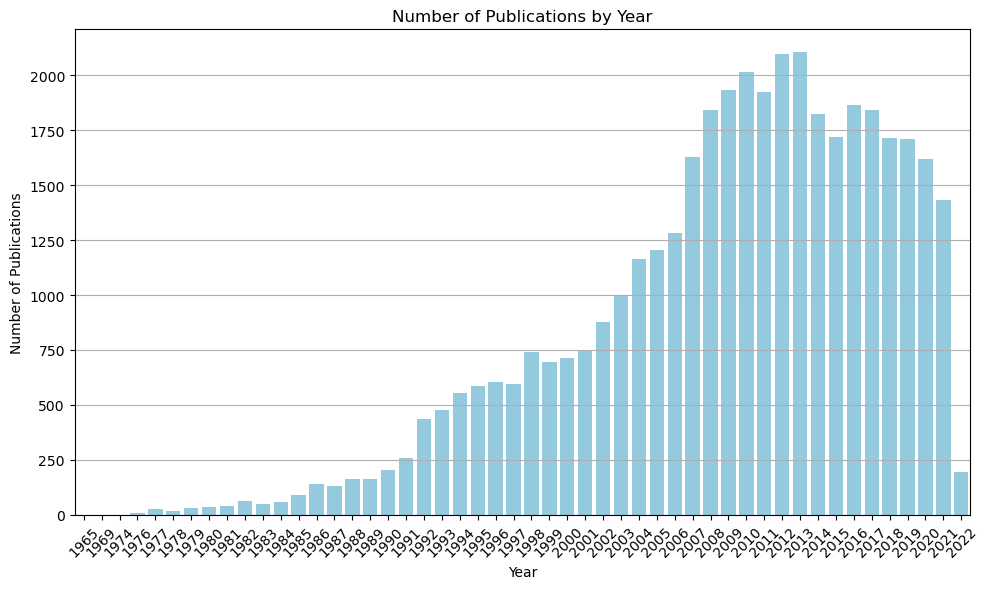

In [74]:
# Count the number of publications per year
yearly_counts = df_date['Year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, color='skyblue')
plt.title('Number of Publications by Year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [75]:
df_date.head(10)

,Unnamed: 0,DOI,Publication Date,Year
0,0,10.1021/jm9602571,1996-01-01,1996
1,1,10.1016/j.chembiol.2013.07.014,2013-09-01,2013
2,2,10.1021/jm9507183,1996-01-01,1996
3,3,10.1126/science.2200122,1990-08-03,1990
4,4,10.1021/ja00082a004,1994-02-01,1994
5,5,10.1021/jm960022p,1996-01-01,1996
6,6,10.1021/jm020230j,2002-11-01,2002
7,7,10.1074/jbc.273.49.32608,1998-12-01,1998
8,8,10.1016/0960-894X(95)00461-2,1995-11-01,1995
9,9,10.1016/0960-894X(95)00507-P,1995-12-01,1995


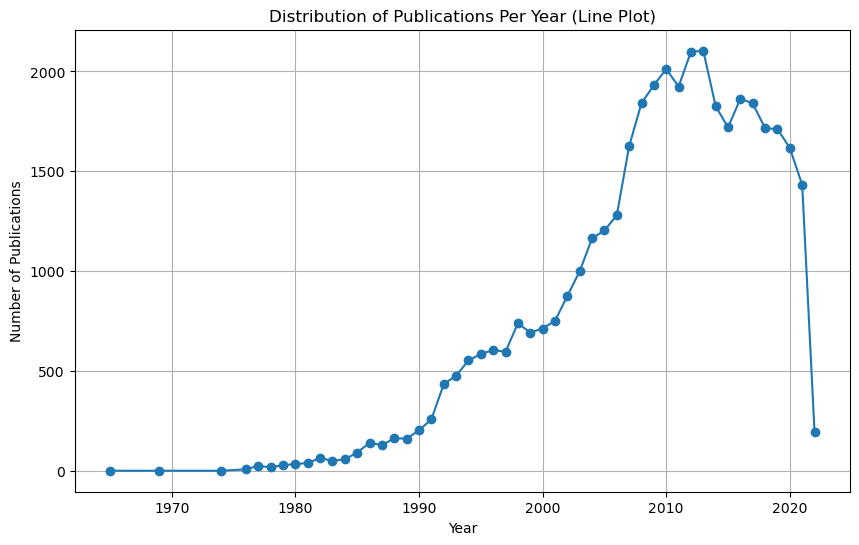

In [76]:
# Line plot of publication counts per year
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', linestyle='-')
plt.title('Distribution of Publications Per Year (Line Plot)')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.show()

### Test country
uncomment from the function the name part

In [ ]:
idxs= np.random.randint(0,len(dois),size = 2000)

In [ ]:
names = []
for idx in tqdm(idxs):
    doi = dois[idx]
    pub_date,name = get_publication_date(doi,debugging=False)
    if name == 'NaN':
        name = np.nan
    names.append(name)

In [ ]:
# Convert list to Series and apply isna()
count = pd.Series(names).isna().sum()
print(count)

1339


### Date with other columns pair analysis

Here we analyze what columns can be analyzed with the date:
- check the amount of data left after cleaning the column pair (removing NaN rows).
- check data spread over the years

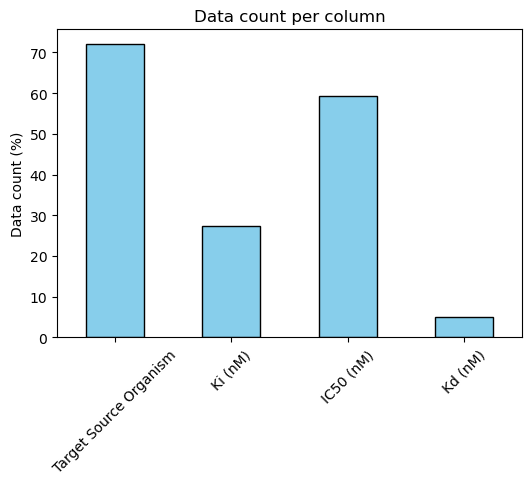

In [77]:
columns_to_check = ['Target Source Organism','Ki (nM)', 'IC50 (nM)', 'Kd (nM)']
counts = df_copy[columns_to_check].notna().sum()/len(df_copy)*100

# Plot histogram of non-NaN counts
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Data count per column")
plt.ylabel("Data count (%)")
plt.xticks(rotation=45)
plt.show()

In [78]:
df_date.rename(columns={"DOI": "Article DOI"}, inplace=True)
df_merged = df_copy.merge(df_date, on='Article DOI', how='left')

df_merged.sample(10)

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Secondary ID(s) of Target Chain.12,UniProt (SwissProt) Alternative ID(s) of Target Chain.12,UniProt (TrEMBL) Submitted Name of Target Chain.12,UniProt (TrEMBL) Entry Name of Target Chain.12,UniProt (TrEMBL) Primary ID of Target Chain.12,UniProt (TrEMBL) Secondary ID(s) of Target Chain.12,UniProt (TrEMBL) Alternative ID(s) of Target Chain.12,Unnamed: 0,Publication Date,Year
1068919,50966162,Cc1[nH]nc(C(O)=O)c1Cc1ccc(cc1)-c1ccc(F)cc1,InChI=1S/C18H15FN2O2/c1-11-16(17(18(22)23)21-2...,YQTHWADQHPPUSO-UHFFFAOYSA-N,50396210,CHEMBL2172030,2-Hydroxyacid oxidase 2,Rattus norvegicus,NaN,400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28232.0,2012-07-01,2012.0
161905,50056284,CC(C)(Oc1ccccc1F)C1OCC(C\C=C/CCC(O)=O)C(O1)c1c...,"InChI=1S/C24H28FNO5/c1-24(2,31-20-12-7-6-11-19...",NJWKDECCDCFCCL-ARJAWSKDSA-N,50036388,(Z)-6-{2-[1-(2-Fluoro-phenoxy)-1-methyl-ethyl]...,Thromboxane-A synthase,Homo sapiens,NaN,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6147.0,1995-02-01,1995.0
1524071,51426265,CC(C)CCCN1[C@@H](CN([C@H](CC2CCCCC2)N2CCC[C@H]...,InChI=1S/C30H57N7O/c1-21(2)11-9-16-35-27(23(5)...,RYHHZOHHLGFDBC-GDMSQXPWSA-N,50576106,CHEMBL4866532,Melanocortin receptor 5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40040.0,2021-05-13,2021.0
913828,50811023,OCCCN1C(=O)NC(C1=O)(c1ccc(Br)cc1)c1ccc(Br)cc1,InChI=1S/C18H16Br2N2O3/c19-14-6-2-12(3-7-14)18...,RCWSXVLXYQOHTN-UHFFFAOYSA-N,50080106,"5,5-Bis-(4-bromo-phenyl)-3-(3-hydroxy-propyl)-...",Cannabinoid receptor 1,Homo sapiens,103.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24799.0,2002-04-01,2002.0
1225394,51126229,CC(C)[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@@H]2CSSC[C...,InChI=1S/C65H102N24O23S4/c1-29(2)49-62(110)79-...,CGDQOVVZAMQFOF-IWSXZFQGSA-N,50461912,CHEMBL4228263,Neuronal acetylcholine receptor; alpha9/alpha10,Homo sapiens,NaN,15200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32081.0,2018-05-24,2018.0
1344635,51246056,COC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC(O)=O)NC(=...,InChI=1S/C33H33ClN4O9/c1-47-33(46)25(10-11-29(...,IMUQYQYYHDKBJD-QKDODKLFSA-N,50509814,CHEMBL4446243,Catenin beta-1,Homo sapiens,NaN,>400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35772.0,2019-04-11,2019.0
328811,50223275,CC(Oc1ccccc1Br)C1=NCCN1,InChI=1S/C11H13BrN2O/c1-8(11-13-6-7-14-11)15-1...,NFGYJBCMYUYKCI-UHFFFAOYSA-N,50419874,CHEMBL1956192,Alpha-2B adrenergic receptor,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11591.0,2012-03-01,2012.0
943447,50840642,OCc1ccc(cc1)-c1c(OCc2ccccc2)ccc2c1oc(nc2=O)N1C...,InChI=1S/C26H24N2O5/c29-16-18-6-8-20(9-7-18)23...,QCEUNEIPEQFJSO-UHFFFAOYSA-N,50261352,CHEMBL4088661,"Phosphatidylinositol 4,5-bisphosphate 3-kinase...",Homo sapiens,NaN,3070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25441.0,2017-10-01,2017.0
1517311,51419503,FC(F)CN1Cc2cc(ncc2C2=CN=C(NCc3c4CCOc4ccc3F)N3C...,InChI=1S/C25H20F6N6O2/c26-17-1-2-18-13(3-4-39-...,VTJYPZHCSHQJME-UHFFFAOYSA-N,50573354,CHEMBL4854800,Potassium voltage-gated channel subfamily H me...,Homo sapiens,NaN,>30000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39893.0,2021-10-14,2021.0
901426,50798621,Fc1ccc(cc1)C(OCCN1CC2CCC(C1)N2C\C=C\c1cccs1)c1...,InChI=1S/C28H30F2N2OS/c29-23-9-5-21(6-10-23)28...,QOBLMKPRCUFVQW-HNQUOIGGSA-N,50369752,CHEMBL1202014,Sodium-dependent serotonin transporter,Rattus norvegicus,NaN,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24548.0,2000-12-01,2000.0


In [79]:
df_merged.dropna(subset=['Target Source Organism'], inplace=True)
value_counts = df_merged['Target Source Organism'].value_counts()

In [80]:
top_3 = value_counts.index[:3] #select top 3
top_5 = value_counts.index[:5] #select top 5

In [81]:
df_subset_target = df_merged[df_merged['Target Source Organism'].isin(top_5)]

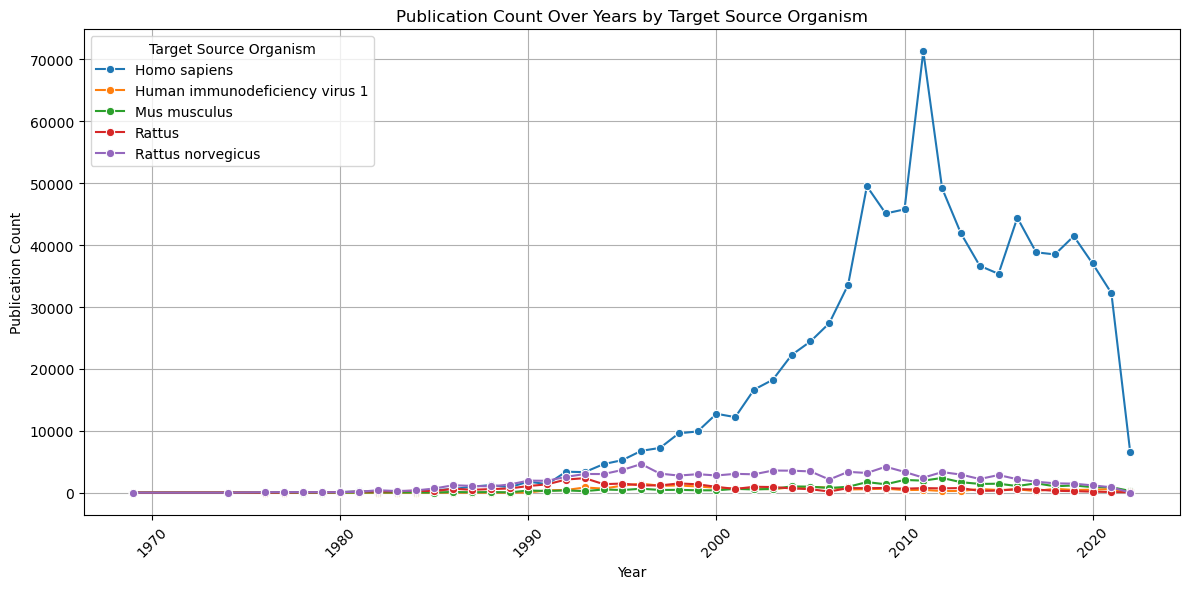

In [82]:
# Count the number of publications per year for each target
publication_counts = df_subset_target.groupby(['Year', 'Target Source Organism']).size().reset_index(name='Count')

# Pivot the DataFrame
pivot_table = publication_counts.pivot(index='Year', columns='Target Source Organism', values='Count').fillna(0)

# Reset index for plotting
pivot_table = pivot_table.reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_table.melt(id_vars='Year', var_name='Target Source Organism', value_name='Count'),
              x='Year', y='Count', hue='Target Source Organism', marker='o')

plt.title('Publication Count Over Years by Target Source Organism')
plt.xlabel('Year')
plt.ylabel('Publication Count')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Target Source Organism')
plt.tight_layout()
plt.show()

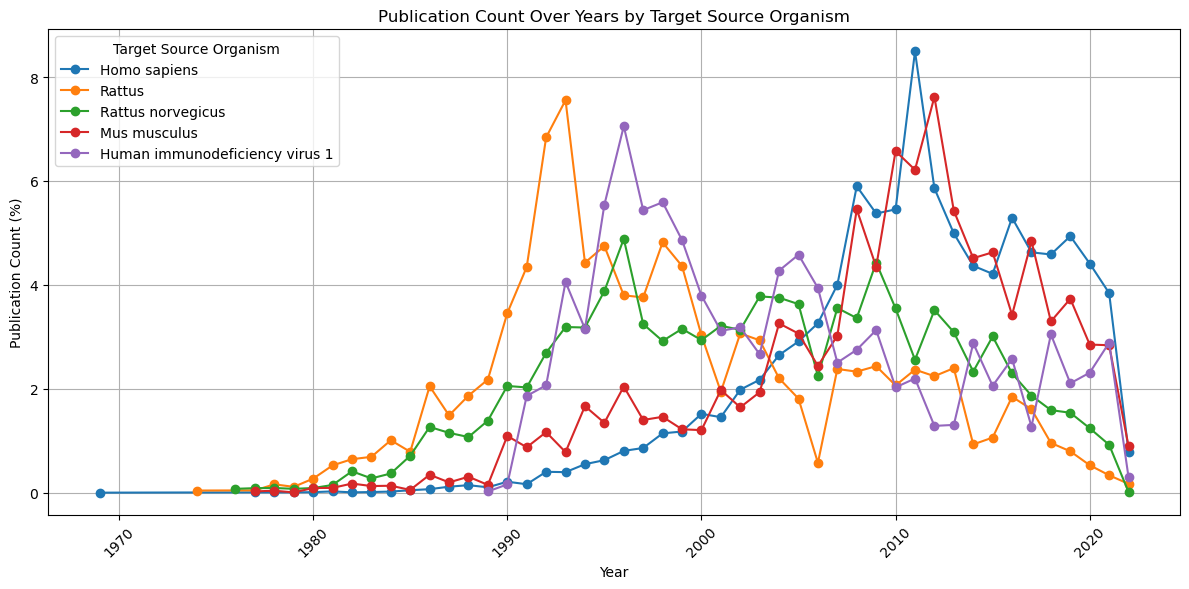

In [83]:
# Count the number of publications per year for each target organism
publication_counts = df_subset_target.groupby(['Year', 'Target Source Organism']).size().reset_index(name='Count')
plt.figure(figsize=(12, 6))
for target in publication_counts['Target Source Organism'].unique():
    # Filter the counts for the specific target organism
    total_count = publication_counts[publication_counts['Target Source Organism'] == target]['Count'].sum()
    target_counts = publication_counts[publication_counts['Target Source Organism'] == target]
    plt.plot(target_counts['Year'], target_counts['Count']/total_count*100, marker='o', label=target)

plt.title('Publication Count Over Years by Target Source Organism')
plt.xlabel('Year')
plt.ylabel('Publication Count (%)')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Target Source Organism')
plt.tight_layout()
plt.show()

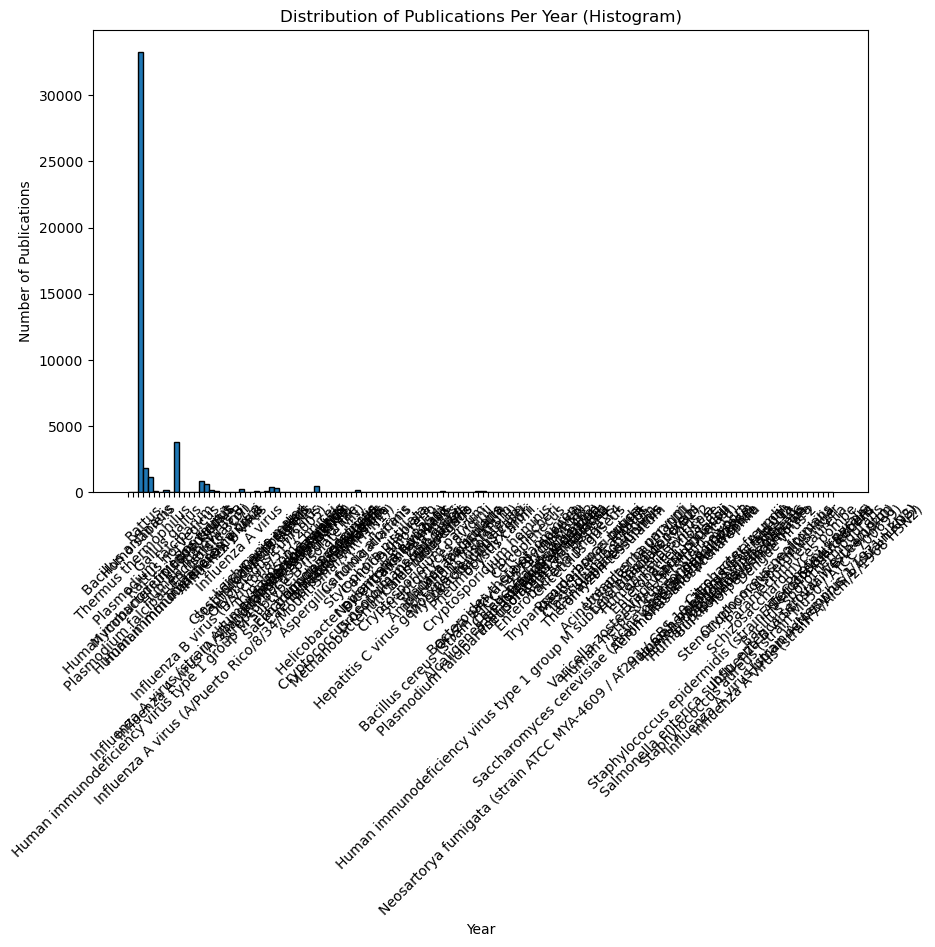

In [195]:
# Histogram plot of publication counts per year
df_merged.dropna(subset=['Target Source Organism'], inplace=True)
plt.figure(figsize=(10, 6))
plt.bar(df_merged['Target Source Organism'], bins=len(df_merged['Target Source Organism'].unique()), edgecolor='black')
plt.title('Distribution of Publications Per Year (Histogram)')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.show()